### Imports

In [ ]:
import os
import sys
import random
from pathlib import Path
from typing import Generator
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
import torchaudio.transforms as AT
import torchaudio.functional as AF
from torchvision import models

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

### Constants

In [ ]:
TARGET_SR = 16000           # think its hard to go lower than 16kHz
CHUNK_DURATION_SEC = 15     # all chunks will be exactly this long
MIN_CHUNK_DURATION_SEC = 5  # discard chunks shorter than this (otherwise zero-pad to CHUNK_DURATION_SEC)

# mel-spectrogram settings (using same as cocola for now)
N_MELS = 64
F_MIN = 60 
F_MAX = 7800
WINDOW_SIZE = 1024 # 64ms @ 16kHz (should be power of 2 for efficiency)
HOP_SIZE = 320     # 20ms @ 16kHz

# Data paths
INPUT_ROOT = "D:/Users/ollet/Downloads/archive_1/Data/genres_stems"
ORIGINALS_ROOT = "D:/Users/ollet/Downloads/archive_1/Data/genres_orginals"

### All functions taken from data_processing folder

In [ ]:
# ---------- Utility functions ----------

def ensure_same_length(tensors: list[torch.Tensor]) -> list[torch.Tensor]:
    min_len = min(len(t) for t in tensors)
    return [t[:min_len] for t in tensors]


def ensure_2d(x: torch.Tensor) -> torch.Tensor:
    if x.ndim == 1:
        return x.unsqueeze(0)
    if x.ndim != 2:
        raise ValueError(f"Input tensor has {x.ndim} dimensions, expected 1 or 2.")
    return x


def mix_stems(stems: list[torch.Tensor], peak_val=0.98) -> torch.Tensor:
    stems = ensure_same_length(stems)
    mixed: torch.Tensor = sum(stems)  # type: ignore
    max_val = mixed.abs().max()
    if max_val > 0:
        mixed = mixed / max_val * peak_val
    return mixed


def zero_pad_or_clip(x: torch.Tensor, target_len: int) -> torch.Tensor:
    if len(x) >= target_len:
        return x[:target_len]
    pad_len = target_len - len(x)
    return torch.cat([x, torch.zeros(pad_len)], dim=0)

def load_audio(path: Path | str, sr: int | float, frame_offset=0, num_frames=-1):
    y, sr = torchaudio.load(path, frame_offset=frame_offset, num_frames=num_frames)
    if y.shape[0] > 1:
        y = y.mean(dim=0, keepdim=True)  # convert to mono
    y = AF.resample(y, orig_freq=sr, new_freq=TARGET_SR)
    return y  # (1, sr*duration)


def get_chunks(vocals: torch.Tensor, non_vocals: torch.Tensor) -> Generator[tuple[torch.Tensor, torch.Tensor], None, None]:
    chunk_frames = CHUNK_DURATION_SEC * TARGET_SR
    min_chunk_frames = MIN_CHUNK_DURATION_SEC * TARGET_SR

    vocals, non_vocals = ensure_same_length([vocals, non_vocals])

    for i, start in enumerate(range(0, len(vocals), chunk_frames)):
        vocals_chunk = vocals[start:start + chunk_frames]
        non_vocals_chunk = non_vocals[start:start + chunk_frames]

        if len(vocals_chunk) < min_chunk_frames:
            continue
        vocals_chunk = zero_pad_or_clip(vocals_chunk, chunk_frames)
        non_vocals_chunk = zero_pad_or_clip(non_vocals_chunk, chunk_frames)

        yield vocals_chunk, non_vocals_chunk


def get_gtzan_track_folders(root: Path | str):
    return sorted(p for p in Path(root).glob("*/*") if p.is_dir())

# ---------- Mel transform ----------

class ToLogMel(nn.Module):
    def __init__(self):
        super().__init__()
        self.to_melspec = AT.MelSpectrogram(
            sample_rate=TARGET_SR,
            n_mels=N_MELS,
            n_fft=WINDOW_SIZE,
            hop_length=HOP_SIZE,
            f_min=F_MIN,
            f_max=F_MAX,
        )
        self.to_db = AT.AmplitudeToDB()

    def forward(self, x: torch.Tensor):
        return self.to_db(self.to_melspec(x))


# ---------- Main dataset with preprocessing ----------

class GTZANStemsDataset(Dataset):
    def __init__(
        self,
        root_dir: Path | str = INPUT_ROOT,
        originals_root: Path | str = ORIGINALS_ROOT,
        preprocess=True,
        preprocess_transform: nn.Module | None = None,
        runtime_transform: nn.Module | None = None,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        self.root = Path(root_dir)
        self.originals_root = Path(originals_root)
        self.processed_root = self.root.parent / (self.root.name + "-processed")

        self.preprocess_transform = preprocess_transform
        self.runtime_transform = runtime_transform
        self.device = device

        if preprocess:
            print(f"Preprocessing GTZAN stems from {self.root} and originals from {self.originals_root}")
            self._preprocess()

        # After preprocessing, load the chunk list
        self.chunk_dirs = sorted([p for p in self.processed_root.glob("*") if p.is_dir()])

    def _preprocess(self):
        """
        Assuming input files like "`self.root`/blues/blues.000001/{drums|bass|other|vocals}.wav":
        1. load as tensors
        2. convert to mono if in stereo
        3. resample (default 16kHz)
        4. mix all non-vocal stems together and discard originals
        5. chunk into `CHUNK_DURATION_SEC` (default 10s) segments, zero-pad last chunk if needed
        6. apply optional `preprocess_transform` (e.g. mel-spectrogram), make sure shapes are correct
        7. save as `self.processed_root`/blues.000001.chunk{1|2|...}/{non-vocals|vocals}.pt
        """
        os.makedirs(self.processed_root, exist_ok=True)
        track_folders = get_gtzan_track_folders(self.root)

        for track_folder in tqdm(track_folders):
            all_stem_paths = list(track_folder.glob("*.wav"))
            assert {p.stem for p in all_stem_paths} == {"drums", "bass", "other", "vocals"}, \
                f"Missing stems for {track_folder}"

            vocals_path = [p for p in all_stem_paths if p.stem == "vocals"][0]
            non_vocals_paths = [p for p in all_stem_paths if p.stem != "vocals"]

            track_name = track_folder.name
            genre = track_folder.parent.name  # e. g. "blues"
            orig_path = self.originals_root / f"{genre}" / f"{track_name}.wav"
            
            # Load and mix stems
            try:
                vocals = load_audio(vocals_path, sr=TARGET_SR)
                non_vocals = mix_stems([load_audio(p, sr=TARGET_SR) for p in non_vocals_paths])
                original = load_audio(orig_path, sr=TARGET_SR)
            except Exception as e:
                print(f"⚠️ Skipping track {track_name} due to loading error: {e}")
                continue
            
            vocals = vocals.squeeze(0)
            non_vocals = non_vocals.squeeze(0)
            original = original.squeeze(0)

            # Generate aligned chunks
            for i, ((vocals_chunk, non_vocals_chunk), (orig_chunk, _)) in enumerate(
                zip(get_chunks(vocals, non_vocals), get_chunks(original, original))
            ):
                if self.preprocess_transform is not None:
                    with torch.no_grad():
                        vocals_chunk = self.preprocess_transform(vocals_chunk.unsqueeze(0))  # (1, T)
                        non_vocals_chunk = self.preprocess_transform(non_vocals_chunk.unsqueeze(0))
                        orig_chunk = self.preprocess_transform(orig_chunk.unsqueeze(0))
                        
                chunk_folder = self.processed_root / f"{track_name}.chunk{i+1}"
                os.makedirs(chunk_folder, exist_ok=True)
                torch.save(vocals_chunk, chunk_folder / "vocals.pt")
                torch.save(non_vocals_chunk, chunk_folder / "non-vocals.pt")
                torch.save(orig_chunk, chunk_folder / "original.pt")

    def __len__(self):
        return len(self.chunk_dirs)

    def __getitem__(self, idx):
        chunk_dir = self.chunk_dirs[idx]
        vocals = torch.load(chunk_dir / "vocals.pt", map_location='cpu', weights_only=False)
        non_vocals = torch.load(chunk_dir / "non-vocals.pt", map_location='cpu', weights_only=False)
        original = torch.load(chunk_dir / "original.pt", map_location='cpu', weights_only=False)

        if self.runtime_transform:
            vocals = self.runtime_transform(vocals)
            non_vocals = self.runtime_transform(non_vocals)
            original = self.runtime_transform(original)

        return {
            "vocals": vocals.to(self.device),
            "non_vocals": non_vocals.to(self.device),
            "original": original.to(self.device),
            "chunk_name": chunk_dir.name,
        }


To create the dataloaders needed to train our model we first need to split the dataset. How we do this is by using train_test_split() on unique track names so that chunks from the same audio files doesn't end up in different splits. 

In [4]:
# ---------- Split dataset by tracks ----------

def split_dataset_by_tracks(dataset: GTZANStemsDataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    # Extract unique track names
    all_tracks = sorted({p.name.split(".chunk")[0] for p in dataset.chunk_dirs})
    
    train_tracks, temp_tracks = train_test_split(all_tracks, test_size=(1 - train_ratio), random_state=random_state)
    val_tracks, test_tracks = train_test_split(temp_tracks, test_size=test_ratio / (test_ratio + val_ratio), random_state=random_state)

    def get_chunk_indices(track_list):
        return [i for i, chunk_dir in enumerate(dataset.chunk_dirs) if chunk_dir.name.split(".chunk")[0] in track_list]

    train_dataset = Subset(dataset, get_chunk_indices(train_tracks))
    val_dataset = Subset(dataset, get_chunk_indices(val_tracks))
    test_dataset = Subset(dataset, get_chunk_indices(test_tracks))

    return train_dataset, val_dataset, test_dataset

# ---------- DataLoaders ----------

def create_dataloaders(preprocess=False, batch_size=16, num_workers=0):
    dataset = GTZANStemsDataset(preprocess=preprocess, preprocess_transform=ToLogMel())

    train_dataset, val_dataset, test_dataset = split_dataset_by_tracks(dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

Below is a test to see the shapes of vocals, non-vocals, etc.

In [5]:
train_loader, val_loader, _ = create_dataloaders(batch_size=4)
# Get one batch from the training dataloader
batch = next(iter(train_loader))

# Print keys
print(batch.keys())
print("Vocals:", batch['vocals'].shape) # [batch_size, channels, n_mels, time] if using Mel
print("Non-vocals:", batch['non_vocals'].shape)
print("Original:", batch['original'].shape)
print("Chunk names:", batch['chunk_name'])   # List of strings

dict_keys(['vocals', 'non_vocals', 'original', 'chunk_name'])
Vocals: torch.Size([4, 1, 64, 751])
Non-vocals: torch.Size([4, 1, 64, 751])
Original: torch.Size([4, 1, 64, 751])
Chunk names: ['blues.00061.chunk2', 'disco.00049.chunk1', 'blues.00093.chunk1', 'classical.00079.chunk1']


### Model and loss functions

CAN BE CHANGED!!! 

I followed the project purposal and created a dual encoder for the vocal + instruments. Currently i have created a CNN + Transformer model for each MusicEncoder but you can simply remove the transformer layer and change the Projection layer if you want to not use transformers. 

For loss function it uses costrastive loss (Cosine similarity) to find the most similar matches.

In [20]:
class MusicEncoder(nn.Module):
    def __init__(self, embedding_dim=128, cnn_name='resnet18', weights='ResNet18_Weights.IMAGENET1K_V1', n_heads=4, n_layers=2):
        super(MusicEncoder, self).__init__()

        # --- Pretrained CNN feature extractor ---
        base_cnn = getattr(models, cnn_name)(weights=weights)
        self.feature_extractor = nn.Sequential(*list(base_cnn.children())[:-2])
        self.cnn_out_channels = 512  # resnet18 output channels

        # --- Transformer encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.cnn_out_channels,
            nhead=n_heads,
            dim_feedforward=1024,
            dropout=0.3,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # --- Projection to embedding ---
        self.fc = nn.Linear(self.cnn_out_channels, embedding_dim)

    def forward(self, x):
        """
        x: [B, 1, n_mels, time]
        """
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # [B,3,H,W] for ResNet

        feats = self.feature_extractor(x)  # [B, C, H', W']
        B, C, H, W = feats.shape

        # Collapse frequency dimension
        feats = feats.mean(dim=2)           # [B, C, time]
        feats = feats.transpose(1, 2)       # [B, time, C]

        feats = self.transformer(feats)     # temporal modeling
        pooled = feats.mean(dim=1)          # global average pooling

        emb = self.fc(pooled)
        emb = F.normalize(emb, p=2, dim=1)  # L2-normalize
        return emb


In [7]:
class DualEncoderModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super(DualEncoderModel, self).__init__()
        self.vocal_encoder = MusicEncoder(embedding_dim)
        self.instr_encoder = MusicEncoder(embedding_dim)

    def forward(self, vocals, non_vocals):
        v_emb = self.vocal_encoder(vocals)
        i_emb = self.instr_encoder(non_vocals)
        return v_emb, i_emb


In [8]:
def contrastive_loss(v_emb, i_emb, temperature=0.07):
    """
    InfoNCE-style contrastive loss using cosine similarity between normalized embeddings.
    """
    # Normalize embeddings
    v_emb = F.normalize(v_emb, dim=-1)
    i_emb = F.normalize(i_emb, dim=-1)

    # Cosine similarity matrix scaled by temperature
    sim_matrix = torch.matmul(v_emb, i_emb.T) / temperature  # [B, B]

    # Targets: diagonal elements are positives
    targets = torch.arange(v_emb.size(0), device=v_emb.device)

    # Cross-entropy loss in both directions
    loss_v2i = F.cross_entropy(sim_matrix, targets)
    loss_i2v = F.cross_entropy(sim_matrix.T, targets)

    return (loss_v2i + loss_i2v) / 2

In [ ]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    epochs=50, 
    lr=1e-4, 
    weight_decay=1e-5,
    save_path="dual_encoder_best.pth", 
    device=None,
    early_stopping_patience=5,
    use_spec_augment=False
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"🚀 Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    early_stop_counter = 0

    # Optional spec augmentation
    if use_spec_augment:
        freq_mask = AT.FrequencyMasking(freq_mask_param=15)
        time_mask = AT.TimeMasking(time_mask_param=20)
        print("🎨 Using SpecAugment for data augmentation")

    print(f"🚀 Starting training for {epochs} epochs...\n")

    for epoch in range(1, epochs + 1):
        print(f"\n--- Epoch {epoch}/{epochs} ---")

        # -------------------- TRAIN --------------------
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            # Load tensors and move to GPU safely
            vocals = batch["vocals"].float()
            non_vocals = batch["non_vocals"].float()

            if use_spec_augment:
                vocals = freq_mask(vocals)
                vocals = time_mask(vocals)
                non_vocals = freq_mask(non_vocals)
                non_vocals = time_mask(non_vocals)

            vocals = vocals.to(device)
            non_vocals = non_vocals.to(device)

            # Forward pass
            v_emb, i_emb = model(vocals, non_vocals)
            loss = contrastive_loss(v_emb, i_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f"[Train] Batch {batch_idx}, Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        print(f"[Epoch {epoch}] Avg train loss: {avg_train_loss:.4f}")

        # -------------------- VALIDATE --------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                vocals = batch["vocals"].float().to(device)
                non_vocals = batch["non_vocals"].float().to(device)
                v_emb, i_emb = model(vocals, non_vocals)
                loss = contrastive_loss(v_emb, i_emb)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"[Epoch {epoch}] Avg val loss: {avg_val_loss:.4f}")

        # Scheduler step
        scheduler.step(avg_val_loss)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        # Save best model & handle early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model to {save_path}")
        else:
            early_stop_counter += 1
            print(f"⚠️ No improvement for {early_stop_counter} epochs")
            if early_stop_counter >= early_stopping_patience:
                print(f"🛑 Early stopping triggered after {early_stop_counter} epochs without improvement")
                break

    print("\n🎯 Training complete!")
    print(f"Lowest validation loss: {best_val_loss:.4f}")
    return history


### How to train model (Using GPU)
1. If you are running through Google Colab, switch to GPU at the top right hand corner. After that you can start Training.
2. If run locally, first install CUDA Toolkit and cuDNN Library.
3. Create an environment through anaconda or other means.
4. Install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia.
5. Create a jupyter kernel and then start the environment through a jupyter notebook.
6. Start Training!

Make sure these prints below returns the correct values to make sure you are using a GPU:

In [11]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs

True
1


In [25]:
# Load dataloaders
train_loader, val_loader, _ = create_dataloaders(batch_size=16)

In [ ]:
# Initialize model
model = DualEncoderModel(embedding_dim=128)
# Train model
history = train_model(model, train_loader, val_loader, epochs=50, lr=1e-6, save_path="dual_encoder_best.pth")

🚀 Using device: cuda
🎨 Using SpecAugment
🚀 Starting training for 50 epochs...


--- Epoch 1/50 ---
[Train] Batch 0, Loss: 3.4906
[Train] Batch 10, Loss: 3.2554
[Train] Batch 20, Loss: 2.7781
[Train] Batch 30, Loss: 3.2302
[Train] Batch 40, Loss: 2.9639
[Train] Batch 50, Loss: 2.6298
[Train] Batch 60, Loss: 2.7700
[Train] Batch 70, Loss: 3.1302
[Train] Batch 80, Loss: 3.0857
[Epoch 1] Avg train loss: 3.1028
[Epoch 1] Avg val loss: 3.1689
✅ Saved new best model to dual_encoder_best.pth

--- Epoch 2/50 ---
[Train] Batch 0, Loss: 2.9375


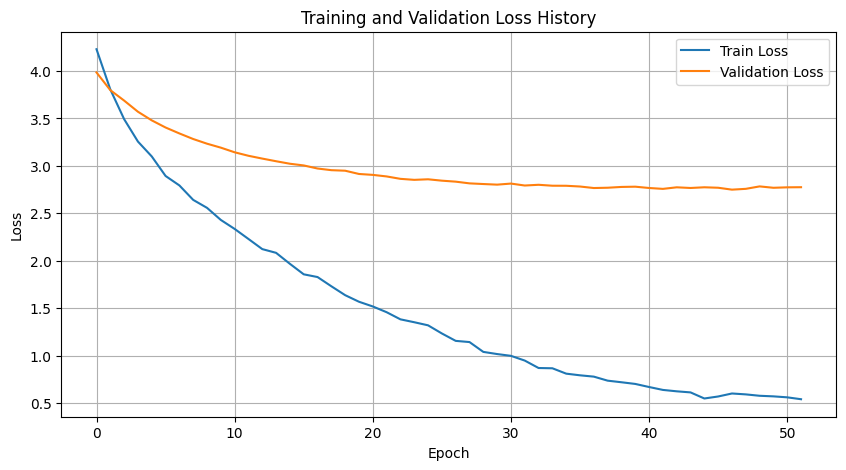

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid(True)
plt.show()